In [5]:
import argparse
import os
import time
import numba as nb
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import scipy
import jax
from jax import vmap
import jax.numpy as jnp
import jax.random as random
from mpl_toolkits.mplot3d import Axes3D
import pylab 
import numpyro
import math
import sys
import time
sys.path.append('.')
sys.path.append('..')
from utils.utils import swill_roll_non_embed_f, swill_roll_non_embed_nuniform_f, swill_roll_line_non_embed_f, swill_roll_curve_non_embed_f
from Codes.Model_class import fill_diagonal, kernel_fromdists, predict_mean_fromdists
from sklearn.manifold import Isomap

In [6]:
# %matplotlib inline
# rng_key, rng_key_predict = random.split(random.PRNGKey(0))

In [7]:
np.random.seed(42)

In [8]:
def swill_roll_f1(U,V):
    return 4 * (U/(3*np.pi)- (1+3*np.pi)/2)**2 + V*np.pi/20

def swill_roll_f2(U,V):
    return 6 * (U/(3*np.pi)- (1+3*np.pi)/2)**2 + V*np.pi/3

def swill_roll_f3(U,V):
    return 3 * (U/(4*np.pi) - (1+4*np.pi)/2)**2 + np.abs(V-7.5) *np.pi/5

def swill_roll_f4(U,V):
    return (3 * ((U-7*np.pi/2)/(3*np.pi/2))**2 + (V-7.5)**2 *np.pi/15)

def swill_roll_f5(U,V):
    return (3 * ((U-7*np.pi/2)/(3*np.pi/2))**2 + (V-7.5)**2 *np.pi/15) + 1

def swill_roll_f4_re_1(U,V):
    return (3 * ((U-7*np.pi/2)/(3*np.pi/2))**2 + (V-7.5)**2 *np.pi/15)/5

def swill_roll_f4_re(U,V):
    return (3 * ((U-7*np.pi/2)/(3*np.pi/2))**2 + (V-7.5)**2 *np.pi/15)/20

def swill_roll_f4_pri_re(U,V):
    return (3 * ((U-7*np.pi/2)/(3*np.pi/2))**2 + (V-7.5)**2 *np.pi/15)/40

0.02603964108139166


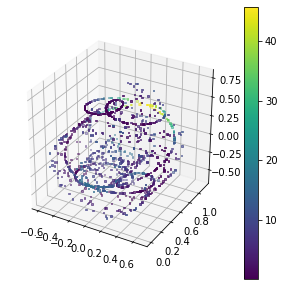

In [9]:
# creating a dummy dataset
swiss_roll_3d, Y_true, Y_noise = swill_roll_curve_non_embed_f(n_data = 1200, f = swill_roll_f4)
print(np.min(Y_true))
swiss_roll_3d = swiss_roll_3d/np.sqrt(346)
x = swiss_roll_3d[:,0]
y = swiss_roll_3d[:,1]
z_1 = swiss_roll_3d[:,2]
colo = Y_true

# creating figures
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111, projection='3d')
  
# setting color bar
color_map = pylab.cm.ScalarMappable()
color_map.set_array(colo)
  
# creating the heatmap
# img = ax.scatter(x, y, z_1, marker='s',
#                  s=2, c=pylab.cm.gist_heat(colo/np.max(colo)))

img = ax.scatter(x, y, z_1, marker='s',
                 s=2, c= colo)
plt.colorbar(color_map)
  
# adding title and labels
#ax.set_title("Swiss_roll_3D True")
# ax.set_xlabel('X-axis', fontsize=15)
# ax.set_ylabel('Y-axis', fontsize=15)
# ax.set_zlabel('Z-axis', fontsize=15)

ax.set_box_aspect([1,1,1])
# displaying plot
plt.show()
#plt.savefig('/Users/tt/Desktop/Git Codes/Research/Gp:Kernel Regression on Unknown Manifold/Figures/swiss_roll_true_3d')

In [10]:
N_num = 6
ls_d_miss = [i for i in range(1,11)]
train_error_means=np.zeros((N_num,len(ls_d_miss)))
train_error_stds=np.zeros((N_num,len(ls_d_miss)))
test_error_means=np.zeros((N_num,len(ls_d_miss)))
test_error_stds=np.zeros((N_num,len(ls_d_miss)))
data_number = [50,100,200,400,800,1600]
dict_num = {num:i for i, num in enumerate(data_number)}
post_means, post_std =np.zeros(N_num), np.zeros(N_num)
weighted_means, weighted_std = np.zeros(N_num), np.zeros(N_num)
w_likelihood_means, w_likelihood_std =np.zeros(N_num), np.zeros(N_num)
w_pos_means, w_pos_std =np.zeros(N_num), np.zeros(N_num)
w_pos_knn_means, w_pos_knn_std =np.zeros(N_num), np.zeros(N_num)
single_means, single_std=np.zeros(N_num), np.zeros(N_num)

post_test_means, post_test_std =np.zeros(N_num), np.zeros(N_num)
weighted_test_means, weighted_test_std =np.zeros(N_num), np.zeros(N_num)
w_pos_test_means, w_pos_test_std=np.zeros(N_num), np.zeros(N_num)
#post_means[dict_num[train_size]], post_std[dict_num[train_size]] =np.mean(ls_w_pos_miss_test), np.std(ls_w_pos_miss_test)
w_pos_knn_test_means, w_pos_knn_test_std =np.zeros(N_num), np.zeros(N_num)
iso_means, iso_std=np.zeros(N_num), np.zeros(N_num)
iso_test_means, iso_test_std=np.zeros(N_num), np.zeros(N_num)

In [11]:
shape = 2
sigmasq_0 = 0.01
replicas = 50
n_grid = 100
train_size = 100
test_size = 2000
n_data = train_size + test_size
k_data= math.ceil(np.log(train_size)**(1.1) * 0.4)
k_data_max = math.ceil(train_size * 0.15)
k_nn_distance = np.zeros(replicas)
k_nn_distance_max =  np.zeros(replicas)
iso_knn_k = 10
k_size = math.ceil(train_size *0.2)

In [12]:
mcmc_time = 3000
burn_in = 1000

In [13]:
ls_epsilons = np.zeros((replicas, mcmc_time ))
log_likelihoods = np.zeros(mcmc_time)
log_pos = np.zeros(mcmc_time )
log_pos_miss = np.zeros((len(ls_d_miss),mcmc_time ))
log_pos_knn = np.zeros(mcmc_time )
ls_insample = np.zeros((replicas,n_grid))
ls_outsample = np.zeros((replicas,n_grid))
ls_insample_iso = np.zeros((replicas,n_grid))
ls_outsample_iso = np.zeros((replicas,n_grid))
ls_weighted = np.zeros(replicas)
ls_w_likelihood = np.zeros(replicas)
ls_w_pos = np.zeros(replicas)
ls_w_pos_miss = np.zeros((replicas, len(ls_d_miss)))
ls_single = np.zeros(replicas)
ls_w_pos_knn = np.zeros(replicas)
ls_weighted_test = np.zeros(replicas)
ls_w_likelihood_test = np.zeros(replicas)
ls_w_pos_test = np.zeros(replicas)
ls_w_pos_miss_test = np.zeros((replicas, len(ls_d_miss)))
#ls_single = np.zeros(replicas)
ls_w_pos_knn_test = np.zeros(replicas)
v_hat = np.zeros((replicas,mcmc_time))

In [14]:
#Choose sigma_proposal and sigma_proposal_knn
#Use grid posterior to look for range (can be rounded)
replica = 0
n_grid = 100
ls_grid_epsilon = np.linspace(10**-6, 0.2, n_grid)
log_grid_likelihoods = np.zeros(n_grid)
log_grid_pos = np.zeros(n_grid)
log_grid_pos_knn = np.zeros(n_grid)
X, Y_de, Y = swill_roll_curve_non_embed_f(n_data = n_data, sigma_noise = np.sqrt(sigmasq_0), f= swill_roll_f4)
X = X / np.sqrt(346)   
idx = np.arange(n_data)
np.random.shuffle(idx)
train_idx, test_idx = idx[:train_size], idx[train_size:]
X_train, X_test = X[train_idx], X[test_idx]
Y_de_train, Y_de_test = Y_de[train_idx], Y_de[test_idx]
Y_train, Y_test = Y[train_idx], Y[test_idx]
dists_XX = scipy.spatial.distance.cdist(X_train, X_train)
dists_pX = scipy.spatial.distance.cdist(X_test, X_train)
k_nn_subtable = np.sort(dists_XX[:k_size, :], axis = 1)
k_nn_distance[replica] = (np.mean(k_nn_subtable [:,k_data]))**2
k_nn_distance_max[replica] = (np.mean(k_nn_subtable [:,k_data_max]))**2
for i, epsilon in enumerate(ls_grid_epsilon):
    k_XX = kernel_fromdists(dists_XX, 1, epsilon, sigmasq_0, include_noise=True)
    k_pX = kernel_fromdists(dists_pX, 1, epsilon, sigmasq_0, include_noise=False)
    k_XX_de = kernel_fromdists(dists_XX, 1, epsilon, sigmasq_0, include_noise=False)
    hat_inverse = jnp.linalg.solve(k_XX, Y_train)
    log_grid_likelihoods[i] = -0.5 * jnp.matmul(Y_train, hat_inverse)
#         log_likelihoods[i] = -0.5 * jnp.matmul(Y_train, jnp.linalg.solve(k_XX, Y_train))
    log_grid_likelihoods[i] += -0.5 * jnp.linalg.slogdet(k_XX)[1]
    #log_pos[i] = log_likelihoods[i] + jnp.log(scipy.stats.invgamma.pdf(x =  epsilon, a = shape, scale = 1))
    log_grid_pos[i] = log_grid_likelihoods[i] - 2 * np.log(epsilon) - 1/epsilon
    R_hat= (k_XX_de.sum(1)-1)/(k_XX_de.shape[1]-1)
    v_hat[replica,i] = np.mean(R_hat)
    log_grid_pos_knn[i] = log_grid_likelihoods[i] - 2 * np.log(epsilon) - 1/v_hat[replica,i]
weight_pos = np.exp(log_grid_pos - np.max(log_grid_pos))
weight_pos = weight_pos/np.sum(weight_pos)
weight_pos_knn = np.exp(log_grid_pos_knn - np.max(log_grid_pos_knn))
weight_pos_knn[ls_grid_epsilon < k_nn_distance[replica]] = 0
weight_pos_knn = weight_pos_knn/np.sum(weight_pos_knn)

/Users/tt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: divide by zero encountered in double_scalars


In [15]:
#Choose sigma_proposal 
#Use grid posterior to look for range (can be rounded)
grid_pos_tolerance = 10**(-10)
ls_grid_select=ls_grid_epsilon[weight_pos >grid_pos_tolerance]

sigma_proposal =(max(ls_grid_select) - min(ls_grid_select))/25
sigma_proposal = np.round(sigma_proposal * 1000)/1000

#Choose sigma_proposal_knn 
#Use grid posterior to look for range (can be rounded)

ls_grid_select=ls_grid_epsilon[weight_pos_knn>grid_pos_tolerance]

sigma_proposal_knn =(max(ls_grid_select) - min(ls_grid_select))/25
sigma_proposal_knn = np.round(sigma_proposal_knn * 1000)/1000

In [16]:
print(sigma_proposal)
print(sigma_proposal_knn)

0.001
0.001


In [17]:
for replica in range(replicas):
    start = time.time()
    #X, Y_de, Y = swill_roll_non_embed_f(n_data = n_data, sigma_noise = np.sqrt(sigmasq_0), f= swill_roll_f4)
    #X, Y_de, Y = swill_roll_line_non_embed_f(n_data = n_data, sigma_noise = np.sqrt(sigmasq_0), f= swill_roll_f4)
    X, Y_de, Y = swill_roll_curve_non_embed_f(n_data = n_data, sigma_noise = np.sqrt(sigmasq_0), f= swill_roll_f4)
    X = X / np.sqrt(346)  
    idx = np.arange(n_data)
    np.random.shuffle(idx)
    train_idx, test_idx = idx[:train_size], idx[train_size:]
    X_train, X_test = X[train_idx], X[test_idx]
    Y_de_train, Y_de_test = Y_de[train_idx], Y_de[test_idx]
    Y_train, Y_test = Y[train_idx], Y[test_idx]
    
    #isomap kernel ridge, embdding distance
    output_isomap = Isomap(n_neighbors= iso_knn_k , max_iter=50).fit(X)
    dists_XX = scipy.spatial.distance.cdist(output_isomap.embedding_[train_idx], output_isomap.embedding_[train_idx])
    dists_pX = scipy.spatial.distance.cdist(output_isomap.embedding_[test_idx], output_isomap.embedding_[train_idx])
    ls_grid_epsilon = np.linspace(10**-6, 0.5, n_grid)
    Y_pred_train = np.zeros((n_grid,train_size))
    Y_pred_test = np.zeros((n_grid,test_size))
    for i, epsilon in enumerate(ls_grid_epsilon):
        k_XX = kernel_fromdists(dists_XX, 1, epsilon, sigmasq_0, include_noise=True)
        k_pX = kernel_fromdists(dists_pX, 1, epsilon, sigmasq_0, include_noise=False)
        k_XX_de = kernel_fromdists(dists_XX, 1, epsilon, sigmasq_0, include_noise=False)
        hat_inverse = jnp.linalg.solve(k_XX, Y_train)
        Y_pred_train[i,:] = jnp.matmul(k_XX_de, hat_inverse)
        Y_pred_test[i,:] = jnp.matmul(k_pX, hat_inverse)
        ls_insample_iso[replica, i] = np.mean(np.power(Y_de_train - Y_pred_train[i,:],2))
        ls_outsample_iso[replica, i] = np.mean(np.power(Y_de_test - Y_pred_test[i,:],2))
    
    #For original distance   
    dists_XX = scipy.spatial.distance.cdist(X_train, X_train)
    dists_pX = scipy.spatial.distance.cdist(X_test, X_train)
    k_nn_subtable = np.sort(dists_XX[:k_size, :], axis = 1)
    k_nn_distance[replica] = (np.mean(k_nn_subtable [:,k_data]))**2
    k_nn_distance_max[replica] = (np.mean(k_nn_subtable [:,k_data_max]))**2 
    
    #single
    ls_single[replica] = np.sqrt(np.mean(np.power(Y_de_train - Y_train,2)))
    
    #kernel ridge
    ls_grid_epsilon = np.linspace(10**-6, 0.5, n_grid)
    Y_pred_train = np.zeros((n_grid,train_size))
    Y_pred_test = np.zeros((n_grid,test_size))
    for i, epsilon in enumerate(ls_grid_epsilon):
        k_XX = kernel_fromdists(dists_XX, 1, epsilon, sigmasq_0, include_noise=True)
        k_pX = kernel_fromdists(dists_pX, 1, epsilon, sigmasq_0, include_noise=False)
        k_XX_de = kernel_fromdists(dists_XX, 1, epsilon, sigmasq_0, include_noise=False)
        hat_inverse = jnp.linalg.solve(k_XX, Y_train)
        Y_pred_train[i,:] = jnp.matmul(k_XX_de, hat_inverse)
        Y_pred_test[i,:] = jnp.matmul(k_pX, hat_inverse)
        ls_insample[replica, i] = np.mean(np.power(Y_de_train - Y_pred_train[i,:],2))
        ls_outsample[replica, i] = np.mean(np.power(Y_de_test - Y_pred_test[i,:],2))
    
    #knn prior
    ls_epsilon = np.zeros(mcmc_time)
    ls_epsilon[0] = 0.1
    Y_pred_train = np.zeros((mcmc_time,train_size))
    Y_pred_test = np.zeros((mcmc_time,test_size))
    for i in range(1, mcmc_time):  
        #gaussian proposal
        epsilon = (np.random.randn(1)*sigma_proposal_knn + ls_epsilon[i-1]) % 1
        k_XX = kernel_fromdists(dists_XX, 1, epsilon, sigmasq_0, include_noise=True)
        k_pX = kernel_fromdists(dists_pX, 1, epsilon, sigmasq_0, include_noise=False)
        k_XX_de = kernel_fromdists(dists_XX, 1, epsilon, sigmasq_0, include_noise=False)
        hat_inverse = jnp.linalg.solve(k_XX, Y_train)
        log_likelihoods[i] = -0.5 * jnp.matmul(Y_train, hat_inverse)
        log_likelihoods[i] += -0.5 * jnp.linalg.slogdet(k_XX)[1]
        R_hat= (k_XX_de.sum(1)-1)/(k_XX_de.shape[1]-1)
        v_hat[replica,i] = np.mean(R_hat)
        log_pos_knn[i] = log_likelihoods[i] - 2 * np.log(epsilon) - 1/v_hat[replica,i]
        log_pos_raio = min(0., log_pos_knn[i] - log_pos_knn[i-1])
        accept_flag = np.log(np.random.uniform(0,1)) <= log_pos_raio
        if accept_flag and (epsilon >= k_nn_distance[replica]):
            ls_epsilon[i] = epsilon
            Y_pred_train[i,:] = jnp.matmul(k_XX_de, hat_inverse)
            Y_pred_test[i,:] = jnp.matmul(k_pX, hat_inverse)
        else:
            ls_epsilon[i] = ls_epsilon[i-1]
            Y_pred_train[i,:] = Y_pred_train[i-1,:]
            Y_pred_test[i,:] = Y_pred_test[i-1,:]
    err_in = np.sqrt(np.mean((Y_de_train - np.mean(Y_pred_train[burn_in:], axis = 0))**2))
    err_te = np.sqrt(np.mean((Y_de_test - np.mean(Y_pred_test[burn_in:], axis = 0))**2))
    ls_w_pos_knn[replica] = err_in
    ls_w_pos_knn_test[replica] = err_te
    
    #Rescaled gamma prior
    ls_epsilon = np.zeros(mcmc_time)
    ls_epsilon[0] = 0.1
    Y_pred_train = np.zeros((mcmc_time,train_size))
    Y_pred_test = np.zeros((mcmc_time,test_size))
    for i in range(1, mcmc_time):  
        #epsilon = (np.random.uniform(-1, 1)*0.005 + ls_epsilon[i-1]) % 1
        epsilon = (np.random.randn(1)*sigma_proposal + ls_epsilon[i-1]) % 1
        k_XX = kernel_fromdists(dists_XX, 1, epsilon, sigmasq_0, include_noise=True)
        k_pX = kernel_fromdists(dists_pX, 1, epsilon, sigmasq_0, include_noise=False)
        k_XX_de = kernel_fromdists(dists_XX, 1, epsilon, sigmasq_0, include_noise=False)
        hat_inverse = jnp.linalg.solve(k_XX, Y_train)
        log_likelihoods[i] = -0.5 * jnp.matmul(Y_train, hat_inverse)
        log_likelihoods[i] += -0.5 * jnp.linalg.slogdet(k_XX)[1]
        log_pos[i] = log_likelihoods[i] - 2 * np.log(epsilon) - 1/epsilon
        log_pos_raio = min(0., log_pos[i] - log_pos[i-1])
        accept_flag = np.log(np.random.uniform(0,1)) <= log_pos_raio
        if accept_flag:
            ls_epsilon[i] = epsilon
            Y_pred_train[i,:] = jnp.matmul(k_XX_de, hat_inverse)
            Y_pred_test[i,:] = jnp.matmul(k_pX, hat_inverse)
        else:
            ls_epsilon[i] = ls_epsilon[i-1]
            Y_pred_train[i,:] = Y_pred_train[i-1,:]
            Y_pred_test[i,:] = Y_pred_test[i-1,:]
    err_in = np.sqrt(np.mean((Y_de_train - np.mean(Y_pred_train[burn_in:], axis = 0))**2))
    err_te = np.sqrt(np.mean((Y_de_test - np.mean(Y_pred_test[burn_in:], axis = 0))**2))
    ls_w_pos[replica] = err_in
    ls_w_pos_test[replica] = err_te
    
    print(f"{replica} round time: {time.time() - start}")
    

0 round time: 25.62671732902527
1 round time: 25.719704151153564
2 round time: 26.583053827285767
3 round time: 27.04890489578247
4 round time: 25.77720308303833
5 round time: 23.793926239013672
6 round time: 23.99862813949585
7 round time: 22.790003061294556
8 round time: 21.85543727874756
9 round time: 22.11418080329895
10 round time: 22.355315923690796
11 round time: 22.03780508041382
12 round time: 21.989739894866943
13 round time: 21.939446926116943
14 round time: 22.000017881393433
15 round time: 21.945605993270874
16 round time: 22.042693853378296
17 round time: 21.89761734008789
18 round time: 21.959740161895752
19 round time: 21.964003086090088
20 round time: 22.000980854034424
21 round time: 22.863046884536743
22 round time: 22.55078911781311
23 round time: 23.620657920837402
24 round time: 23.114486694335938
25 round time: 23.67320990562439
26 round time: 23.097427129745483
27 round time: 23.721698760986328
28 round time: 23.651650190353394
29 round time: 23.77288317680359
3

In [18]:
#kernel ridge final selection
ls_kernel_ridge =np.sqrt(np.array([ls_insample[enum, item] for enum, item in enumerate(np.argsort(ls_insample)[:,math.ceil(n_grid/5)])]))
ls_kernel_ridge_iso =np.sqrt(np.array([ls_insample_iso[enum, item] for enum, item in enumerate(np.argsort(ls_insample_iso)[:,math.ceil(n_grid/5)])]))
ls_kernel_ridge_test = np.sqrt(np.array([ls_outsample[enum, item] for enum, item in enumerate(np.argsort(ls_insample)[:,math.ceil(n_grid/5)])]))
ls_kernel_ridge_iso_test =np.sqrt(np.array([ls_outsample_iso[enum, item] for enum, item in enumerate(np.argsort(ls_insample_iso)[:,math.ceil(n_grid/5)])]))

In [19]:
print("IS error mean and std")
print(f"kernel ridge:  {np.mean(ls_kernel_ridge)} {np.std(ls_kernel_ridge)}")
print(f"kernel ridge with isomap:  {np.mean(ls_kernel_ridge_iso)} {np.std(ls_kernel_ridge_iso)}")
print(f"rescaled gamma posterior:  {np.mean(ls_w_pos)} {np.std(ls_w_pos)}")
print(f"knn posterior:  {np.mean(ls_w_pos_knn)} {np.std(ls_w_pos_knn)}")
print(f"singe point: {np.mean(ls_single)} {np.std(ls_single)}")

IS error mean and std
kernel ridge:  0.1906227913318024 0.011622105689057718
kernel ridge with isomap:  3.284912783556312 0.8200239047206481
rescaled gamma posterior:  0.17043479993740362 0.013330241327145671
knn posterior:  0.17015915707960552 0.013307732070546861
singe point: 0.09979291866224417 0.006691217188068913


In [20]:
print("OS error mean and std")
print(f"kernel ridge:  {np.mean(ls_kernel_ridge_test)}  {np.std(ls_kernel_ridge_test)}")
print(f"kernel ridge with isomap:  {np.mean(ls_kernel_ridge_iso_test)} {np.std(ls_kernel_ridge_iso_test)}")
print(f"rescaled gamma posterior:  {np.mean(ls_w_pos_test)} {np.std(ls_w_pos_test)}")
print(f"knn posterior:  {np.mean(ls_w_pos_knn_test)} {np.std(ls_w_pos_knn_test)}")

OS error mean and std
kernel ridge:  1.007524067206343  0.19225534135890932
kernel ridge with isomap:  6.793941811718998 1.1057322709055641
rescaled gamma posterior:  1.148734228912908 0.2486128764869467
knn posterior:  1.1508597260651285 0.24940764793520195
